In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.api as sm
import os
import csv

In [3]:
# Here we're cleaning our data and getting it into a dataframe

list_files = os.listdir("./cleanAssets")
idx_to_bank = {}
num_files = len(list_files)
data = None
j = 0
for file in list_files:
    idx_to_bank[j] = file
    print(j)
    print(file)
    file_path = "./cleanAssets/" + file
    total_str = ""
    if (os.path.isfile(file_path)):
        df = pd.read_csv(file_path)
        if df.shape[0] == 91:
            tempValues = list(df[[df.columns[1]]].values.T)[0]
            if('Thousands' in str(df.columns[0])):
                for i in range(len(tempValues)):
                    #print(tempValues[i])
                    if tempValues[i] == '-':
                        tempValues[i] = 0
                    elif '%' not in tempValues[i]:
                        tempValues[i] =float(tempValues[i]) * 1000
                    elif '%' in tempValues[i]:
                        tempValues[i] = float(tempValues[i].replace('%',''))
                    elif math.isnan(tempValues[i]):
                        tempValues[i] = 0

            elif('Millions' in str(df.columns[0])):
                for i in range(len(tempValues)):
                    #print(tempValues[i])
                    if tempValues[i] == '-':
                        tempValues[i] = 0
                    elif '%' not in tempValues[i]:
                        tempValues[i] =float(tempValues[i]) * 1000000
                    elif '%' in tempValues[i]:
                        tempValues[i] = float(tempValues[i].replace('%',''))
                    elif math.isnan(tempValues[i]):
                        tempValues[i] = 0

                        
            else:
                print('new factor')

            tempHeader = df[df.columns[0]].values.T
            tempValues = np.array([tempValues])
            tempdf = pd.DataFrame(tempValues, index=[j], columns = tempHeader)
            if j == 0:
                data = tempdf
            else:
                data = pd.concat([data, tempdf])

            j += 1
        else:
            print('skipped')

            
data['cash over deposits'] = data['Total Cash & Due from Banks']/data['Total Deposits']

0
United Security Bancshares .csv
1
First Interstate BancSystem Inc. .csv
2
C&F Financial Corporation .csv
3
Riverview Bancorp Inc .csv
4
Farmers National Banc Corp. .csv
5
Heritage Commerce Corp .csv
6
Webster Financial Corporation .csv
7
Civista Bancshares Inc. .csv
8
ServisFirst Bancshares Inc. .csv
9
John Marshall Bancorp Inc. .csv
10
Bank of Hawaii Corporation .csv
11
PNC Financial Services Group Inc..csv
12
Popular Inc. .csv
13
Auburn National Bancorporation Inc. .csv
14
Citizens Holding Company .csv
15
Mid-Southern Bancorp Inc. .csv
16
Cadence Bank .csv
17
Cullen Frost Bankers Inc. .csv
18
SouthState Corporation .csv
19
Community Bank System Inc. .csv
20
Pinnacle Financial Partners Inc. .csv
21
Western Alliance Bancorporation  .csv
22
Valley National Bancorp .csv
23
Oak Valley Bancorp .csv
24
CNB Financial Corporation .csv
25
balance-sheet.csv
skipped
25
Metropolitan Bank Holding Corp. .csv
26
Landmark Bancorp Inc. .csv
27
Horizon Bancorp Inc. .csv
28
Union Bankshares Inc. .csv


In [5]:
# The metrics we're going to cluster in our model are the following:
# Total Assets Growth
# Deposits Growth
# Equity / Total Assets
# Cash on Hand

# Below, we store this information for each of the failed banks as follows so we can distinguish them on our graphs:
# SVB, Union Bank, Signature Bank, and Silvergate

svb = data.iloc[123,:]
union = data.iloc[28,:]
sig = data.iloc[55, :]
silv = data.iloc[287, :]
first = data.iloc[192, :]

list_banks = [svb,union,sig,silv, first]

# Summary of our metrics for each failed bank
for i in list_banks:
    print(f"Total Shareholders Equity / Total Assets: {i['Total Shareholders Equity / Total Assets']}")
    print(f"Deposits Growth: {i['Deposits Growth']}")
    print(f"Total Assets Growth: {i['Assets - Total Growth']}")
    cash_on_hand = i['Total Cash & Due from Banks']
    total_deposits = i['Total Deposits']
    print(f"Cash on hand: {float(cash_on_hand)/float(total_deposits)}")
    print("\n")

Total Shareholders Equity / Total Assets: 7.56
Deposits Growth: -8.51
Total Assets Growth: -0.1
Cash on hand: 0.05266046248317534


Total Shareholders Equity / Total Assets: 4.12
Deposits Growth: 9.76
Total Assets Growth: 10.83
Cash on hand: 0.004159733777038269


Total Shareholders Equity / Total Assets: 7.24
Deposits Growth: -16.53
Total Assets Growth: -6.78
Cash on hand: 0.06631674003837905


Total Shareholders Equity / Total Assets: 5.31
Deposits Growth: -55.94
Total Assets Growth: -29.07
Cash on hand: 0.08829601397490869


Total Shareholders Equity / Total Assets: 8.18
Deposits Growth: 12.87
Total Assets Growth: 17.41
Cash on hand: 0.02427495366618113




In [6]:
# Define our GMM function for 2 columns
# Used starter code from GMM homework!! 

def GMM(dat, k):
    
    #Comments will reference slides 26-31 from Feb 9
    
    """Define the variables we will use in the Algorithm"""
    #This represents Σ_m (covariance matrix of each component) (slide 26)
    covars=np.zeros((k,2,2))
    
    #This represents μ_m (mean values of each component) (slide 26)
    means=np.zeros((k,2))
    
    #This represents W_m (weights/likelihood of each component) (slide 26 bottom)
    p_class=np.zeros(k)
    
    #This represents P(x_i | cluster = m), or Φ(x_i | μ_m, Σ_m) (slide 27)
    #During the Expectation step, we will use this to derive p̂_mi (or p_class_given_data) as shown on slide 27
    #p_class_given_data will be the same shape
    
    # Use p_data_given_class to derive p_mi for expectation step. 
    p_data_given_class=np.zeros((len(dat),k))
    
    p_class_given_data=np.zeros((len(dat),k))
    

    
    """Initialize means, covs, p_classes"""
    #initializations of starting points (used to set the initial means below)
    init_idx=np.random.choice(range(len(dat)), size=k, replace=False)
    # we get k indices of random data points. 
    #Initialize the covariance matrix, the means, and the p_class for each of k components (dims)
    for dim in range(k):
        #Set the cov matrix of each component to the cov of the entire dataset (slide 26)
        # changes rows into columns and columns into rows
        # this rets a 2x2 covariance, we set it for each dimension
        covars[dim,:,:]=np.cov(np.transpose(dat))
        

        #Set initial means to initial chosen data points (slide 26)
        # we just set to some data points we have.
        
        # Remember we picked dim number of random indices. Now we're just getting that random number and setting the means to it
        # the means[dim,:] means setting latitude and longitude
        means[dim,:]=dat.iloc[init_idx[dim]]
        
        #Give each component equal weighting / likelihood to start (slide 26)
        p_class[dim]=1/k
    
    for step in range(50):
        # we run it 50 times to get to a convergence of our means, covars, etc. for each cluster
        """Expectation Step (Slide 27)"""
        for i in range(len(dat)):
            for dim in range(k):
                x = dat.iloc[i,0]
                y = dat.iloc[i,1]
    
                # gives us unnormalized probability of being in each cluster
                pmi = stats.multivariate_normal.pdf(x=(x,y), mean=means[dim], cov=covars[dim,:,:], allow_singular=True)
                p_data_given_class[i][dim] = pmi*p_class[dim]

        # normalize them now
        for i in range(len(dat)):
            summ = sum(p_data_given_class[i])
            for dim in range(k):
                p_class_given_data[i][dim] = p_data_given_class[i][dim]/summ

        
        new_weights = p_class=np.zeros(k)
        new_means = np.zeros((k,2))
        new_covars = np.zeros((k,2,2))
        for dim in range(k):
            nm = 0
            x_mean_sum = 0
            y_mean_sum = 0
            x_covar = 0
            y_covar = 0
            covar_new = np.zeros((2,2))
            for i in range(len(dat)):
                nm += p_class_given_data[i][dim]
                x_mean_sum += (p_class_given_data[i][dim]*dat.iloc[i,0])
                y_mean_sum += (p_class_given_data[i][dim]*dat.iloc[i,1])
                
            # change weights
            new_weights[dim] = nm/len(dat)
            # change means using nm and mean_sum's calc'd above
            new_means[dim] = [(x_mean_sum/nm),(y_mean_sum/nm)]
            total = np.zeros((2, 2))
            for j in range(len(dat)):
                total += p_class_given_data[j, dim] * np.outer(list(dat.iloc[j,:]) - means[dim], list(dat.iloc[j,:]) - means[dim])
            covars[dim] = total / nm
        
            
        # set all of our new vars
        means = new_means
        p_class = new_weights
            
    return p_class_given_data, means, covars, p_class


In [14]:
# Defined function which allows us to easily run GMM on 2 column dataset and visualize clusters in plot
# (We can cluster 2 of our metrics at a time to obtain visualizations for presentation. in higher dimensions, we
# won't be able to visualize it really)

def run_to_get_2d(col1,col2):
    x = data[col1]
    x = [float(i) for i in x]
    y = data[col2]
    y = [float(i) for i in y]
    new_df = pd.DataFrame(data=x)
    new_df[col2] = y
    print(new_df)
    p_class_given_data_lst = []
    means_lst = []
    covars_lst = []
    p_class_lst = []
    mean_dist_lst = []
    
    k_num = -1

    for i in range(7,8):
        print("Testing for K: " + str(i))
        p_class_given_data, means, covars, p_class = GMM(new_df, i)
        print(means)
        p_class_given_data_lst.append(p_class_given_data)
        means_lst.append(means)
        covars_lst.append(covars)
        p_class_lst.append(p_class)
    
    
    dict_pts = {}
    for idx,d in enumerate(p_class_given_data_lst[k_num]):
        lst = list(d)
        max_value = max(lst)
        index = lst.index(max_value)
        our_point = new_df.iloc[idx,:]
        our_point_lst = list(our_point)
        if index not in dict_pts:
            dict_pts[index] = [our_point_lst]
        else:
            dict_pts[index].append(our_point_lst)
    
    for key, value in dict_pts.items():
        x = [i[0] for i in dict_pts[key]]
        y = [i[1] for i in dict_pts[key]]
        plt.scatter(x,y)
    plt.scatter([i[0] for i in means_lst[k_num]], [i[1] for i in means_lst[k_num]], color="red", label='Centroids')
    
    # Need to get our coords to plot depending on col1 col2
    plt.scatter([float(i[col1]) for i in list_banks],[float(i[col2]) for i in list_banks], color="black", label='Failed Banks')
    plt.title('GMM')
    plt.xlabel(col1)
    plt.ylabel(col2)
    plt.legend()
        
    

         0  Assets - Total Growth
0     8.64                  -2.44
1     9.53                  64.13
2     8.36                   2.99
3     9.77                  -8.80
4     7.16                  -1.46
..     ...                    ...
291   7.28                   1.28
292  12.97                  -4.02
293   9.80                   6.22
294   7.79                   2.12
295   9.42                  11.45

[296 rows x 2 columns]
Testing for K: 7
[[18.82378473  6.39414709]
 [ 8.449217    1.3613973 ]
 [ 8.7601995  16.3360737 ]
 [32.64       -8.21      ]
 [11.49820934 68.57090849]
 [ 9.36009577  5.92605133]
 [10.773099    0.38853099]]


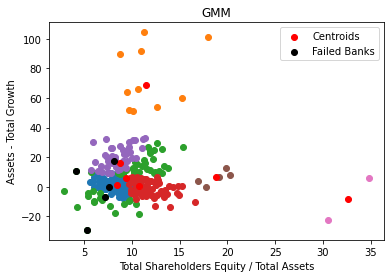

In [15]:
col1 = 'Total Shareholders Equity / Total Assets'
col2 = 'Assets - Total Growth'
run_to_get_2d(col1,col2)


         0  cash over deposits
0     8.64            0.033476
1     9.53            0.013919
2     8.36            0.009980
3     9.77            0.009486
4     7.16            0.005896
..     ...                 ...
291   7.28            0.013841
292  12.97            0.009972
293   9.80            0.134605
294   7.79            0.017133
295   9.42            0.019897

[296 rows x 2 columns]
Testing for K: 7
[[9.45274151e+00 2.33765712e-02]
 [1.36817400e+01 1.01127087e-01]
 [1.08055871e+01 1.10072859e-02]
 [8.71204385e+00 5.39680243e-02]
 [1.06433308e+01 1.25655058e-02]
 [7.97469987e+00 9.34167154e-03]
 [1.87520531e+01 1.27865709e-02]]


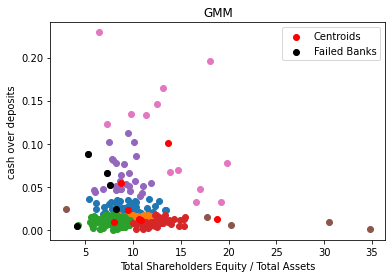

In [16]:
col1 = 'Total Shareholders Equity / Total Assets'
col2 = 'cash over deposits'
run_to_get_2d(col1,col2)

         0  Deposits Growth
0     8.64            -1.90
1     9.53            54.11
2     8.36             4.66
3     9.77           -17.52
4     7.16             0.41
..     ...              ...
291   7.28            -1.79
292  12.97            -9.71
293   9.80             6.34
294   7.79            -2.71
295   9.42            -0.17

[296 rows x 2 columns]
Testing for K: 7
[[ 9.63462513 36.78750026]
 [ 8.78077571  5.54870299]
 [ 8.23795301  0.98409858]
 [10.29470252  1.35113137]
 [20.5585283   0.26118533]
 [10.19082719 -1.61004841]
 [10.56091003 20.01292736]]


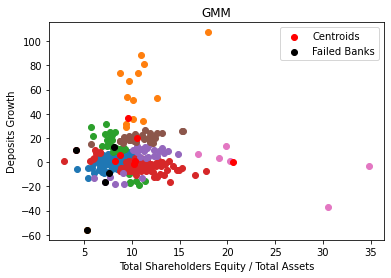

In [18]:
col1 = 'Total Shareholders Equity / Total Assets'
col2 = 'Deposits Growth'
run_to_get_2d(col1,col2)

In [414]:
# Now we want to modify our GMM to work with 4 different dimensions.... mostly just change 2->4 and add variables
# for each dimension we have (mu, weights, var)

def GMM(dat, k):
    
    #Comments will reference slides 26-31 from Feb 9
    
    """Define the variables we will use in the Algorithm"""
    #This represents Σ_m (covariance matrix of each component) (slide 26)
    covars=np.zeros((k,4,4))
    
    #This represents μ_m (mean values of each component) (slide 26)
    means=np.zeros((k,4))
    
    #This represents W_m (weights/likelihood of each component) (slide 26 bottom)
    p_class=np.zeros(k)
    
    #This represents P(x_i | cluster = m), or Φ(x_i | μ_m, Σ_m) (slide 27)
    #During the Expectation step, we will use this to derive p̂_mi (or p_class_given_data) as shown on slide 27
    #p_class_given_data will be the same shape
    
    # Use p_data_given_class to derive p_mi for expectation step. 
    p_data_given_class=np.zeros((len(dat),k))
    
    p_class_given_data=np.zeros((len(dat),k))
    

    
    """Initialize means, covs, p_classes"""
    #initializations of starting points (used to set the initial means below)
    init_idx=np.random.choice(range(len(dat)), size=k, replace=False)
    # we get k indices of random data points. 
    #Initialize the covariance matrix, the means, and the p_class for each of k components (dims)
    for dim in range(k):
        #Set the cov matrix of each component to the cov of the entire dataset (slide 26)
        # changes rows into columns and columns into rows
        # this rets a 2x2 covariance, we set it for each dimension
        covars[dim,:,:]=np.cov(np.transpose(dat))
        

        #Set initial means to initial chosen data points (slide 26)
        # we just set to some data points we have.
        
        # Remember we picked dim number of random indices. Now we're just getting that random number and setting the means to it
        # the means[dim,:] means setting latitude and longitude
        means[dim,:]=dat.iloc[init_idx[dim]]
        
        #Give each component equal weighting / likelihood to start (slide 26)
        p_class[dim]=1/k
    
    for step in range(50):
        for i in range(len(dat)):
            for dim in range(k):
                x = dat.iloc[i,0]
                y = dat.iloc[i,1]
                z = dat.iloc[i,2]
                f = dat.iloc[i,3]
    
                # gives us unnormalized probability of being in each cluster
                pmi = stats.multivariate_normal.pdf(x=(x,y,z,f), mean=means[dim], cov=covars[dim,:,:], allow_singular=True)
                p_data_given_class[i][dim] = pmi*p_class[dim]

        # normalize them now
        for i in range(len(dat)):
            summ = sum(p_data_given_class[i])
            for dim in range(k):
                p_class_given_data[i][dim] = p_data_given_class[i][dim]/summ

        
        """Maximization Step (Slide 29-30)"""
        
        new_weights = p_class=np.zeros(k)
        new_means = np.zeros((k,4))
        new_covars = np.zeros((k,4,4))
        for dim in range(k):
            nm = 0
            x_mean_sum = 0
            y_mean_sum = 0
            z_mean_sum = 0
            f_mean_sum = 0
            x_covar = 0
            y_covar = 0
            z_covar = 0
            f_covar = 0
            covar_new = np.zeros((4,4))
            for i in range(len(dat)):
                nm += p_class_given_data[i][dim]
                x_mean_sum += (p_class_given_data[i][dim]*dat.iloc[i,0])
                y_mean_sum += (p_class_given_data[i][dim]*dat.iloc[i,1])
                z_mean_sum += (p_class_given_data[i][dim]*dat.iloc[i,2])
                f_mean_sum += (p_class_given_data[i][dim]*dat.iloc[i,3])
                
            # change weights
            new_weights[dim] = nm/len(dat)
            # change means using nm and mean_sum's calc'd above
            new_means[dim] = [(x_mean_sum/nm),(y_mean_sum/nm), (z_mean_sum/nm), (f_mean_sum/nm)]
            total = np.zeros((4, 4))
            for j in range(len(dat)):
                total += p_class_given_data[j, dim] * np.outer(list(dat.iloc[j,:]) - means[dim], list(dat.iloc[j,:]) - means[dim])
#             print(nm)
            covars[dim] = total / nm
        
            
        # set all of our new vars
        means = new_means
        p_class = new_weights
            
    return p_class_given_data, means, covars, p_class



In [416]:
# Now, we're going to access our clusters and see what our results are
# Does one cluster include all of our failed banks???

col1 = 'Total Shareholders Equity / Total Assets'
col2 = 'Deposits Growth'
col3 = 'Assets - Total Growth'
col4 = 'cash over deposits'

x = data[col1]
x = [float(i) for i in x]
y = data[col2]
y = [float(i) for i in y]
z = data[col3]
z = [float(i) for i in z]
f = data[col4]
f = [float(i) for i in f]
new_df = pd.DataFrame(data=x)
new_df[col2] = y
new_df[col3] = z
new_df[col4] = f
p_class_given_data_lst = []
means_lst = []
covars_lst = []
p_class_lst = []
mean_dist_lst = []


In [472]:

k_num = -1

for i in range(7,8):
    print("Testing for K: " + str(i))
    p_class_given_data, means, covars, p_class = GMM(new_df, i)
    print(means)
    p_class_given_data_lst.append(p_class_given_data)
    means_lst.append(means)
    covars_lst.append(covars)
    p_class_lst.append(p_class)


dict_pts = {}
for idx,d in enumerate(p_class_given_data_lst[k_num]):
    lst = list(d)
    max_value = max(lst)
    index = lst.index(max_value)
    our_point = new_df.iloc[idx,:]
    our_point_lst = list(our_point)
    if index not in dict_pts:
        dict_pts[index] = [our_point_lst]
    else:
        dict_pts[index].append(our_point_lst)

Testing for K: 7
[[ 9.60960204e+00  2.27338760e+01  2.77406779e+01  3.34321187e-02]
 [ 1.06192695e+01  2.16315189e+01  2.07558919e+01  1.40725899e-01]
 [ 9.77001526e+00  8.30370940e+00  1.09145426e+01  8.26510482e-03]
 [ 8.46758054e+00  9.12229403e-01  6.65705819e+00  2.24535479e-02]
 [ 9.61103107e+00 -2.24017791e-01  7.54681061e-01  1.35410806e-02]
 [ 1.12665973e+01  5.85358910e-01  7.03450780e-01  4.51635580e-02]
 [ 3.26399938e+01 -2.04200487e+01 -8.21004113e+00  5.19228413e-03]]


In [466]:
def vals_to_bank(vals):
    col1 = 'Total Shareholders Equity / Total Assets'
    col2 = 'Deposits Growth'
    col3 = 'Assets - Total Growth'
    col4 = 'cash over deposits'
    for index, row in data.iterrows():
        lst_sea = row[col1]
        lst_dg = row[col2]
        lst_atg = row[col3]
        lst_cod = row[col4]
        if vals[0] == lst_sea and vals[1] == lst_dg and vals[2] == lst_atg and vals[3] == lst_cod:
            return index

In [473]:
# For each one of our banks, output which cluster it's in!!
lst_our_banks = [192,123,28,55,287]
for i in range(7):
    for j in dict_pts[i]:
        if vals_to_bank(j) in lst_our_banks:
            print(i)
    

0
0
0
0
2


As we can see above, 4 out of 5 of our failed banks are in the first cluster! this is great! Now we're going to list the rest of the banks in this cluster as these will be our prediction for banks that will fail next

In [474]:
for i in dict_pts[0]:
    print(idx_to_bank[vals_to_bank(i)])

First Interstate BancSystem Inc. .csv
Webster Financial Corporation .csv
PNC Financial Services Group Inc..csv
First Financial Bankshares Inc. .csv
"Signature Bank **(Failed - Shutdown on Mar 12 2023)**".csv
Stellar Bancorp Inc. .csv
Old National Bancorp .csv
BOK Financial Corporation .csv
ECB Bancorp Inc. .csv
"SVB Financial Group**(Failed - Shutdown on Mar 10 2023)**".csv
Lakeland Bancorp Inc. .csv
York Community Bancorp Inc. .csv
BancFirst Corporation .csv
Republic First Bancorp Inc. .csv
National Bank Holdings Corporation .csv
First Republic Bank.csv
WSFS Financial Corporation .csv
Live Oak Bancshares Inc. .csv
Trustmark Corporation .csv
OptimumBank Holdings Inc. .csv
Southern Missouri Bancorp Inc. .csv
CrossFirst Bankshares Inc. .csv
First Foundation Inc. .csv
Business First Bancshares Inc. .csv
Middlefield Banc Corp. .csv
Bridgewater Bancshares Inc. .csv
First Citizens BancShares Inc. .csv
PB Bankshares Inc. .csv
Silvergate Capital Corporation   (FAILED in March 2023).csv
